# AnoGAN
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# MODEL

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 20)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3852 / G_loss : 0.6693
- D(x) : 0.4991 / D(G(z1)) : 0.4985 / D(G(z2)) : 0.5121
[1/100][1/14]
- D_loss : 1.3943 / G_loss : 0.6546
- D(x) : 0.4991 / D(G(z1)) : 0.5031 / D(G(z2)) : 0.5197
[1/100][2/14]
- D_loss : 1.4034 / G_loss : 0.6430
- D(x) : 0.5005 / D(G(z1)) : 0.5089 / D(G(z2)) : 0.5257
[1/100][3/14]
- D_loss : 1.4167 / G_loss : 0.6301
- D(x) : 0.5009 / D(G(z1)) : 0.5158 / D(G(z2)) : 0.5326
[1/100][4/14]
- D_loss : 1.4277 / G_loss : 0.6197
- D(x) : 0.5021 / D(G(z1)) : 0.5223 / D(G(z2)) : 0.5381
[1/100][5/14]
- D_loss : 1.4424 / G_loss : 0.6095
- D(x) : 0.5017 / D(G(z1)) : 0.5289 / D(G(z2)) : 0.5437
[1/100][6/14]
- D_loss : 1.4557 / G_loss : 0.5970
- D(x) : 0.5033 / D(G(z1)) : 0.5365 / D(G(z2)) : 0.5505
[1/100][7/14]
- D_loss : 1.4688 / G_loss : 0.5888
- D(x) : 0.5030 / D(G(z1)) : 0.5423 / D(G(z2)) : 0.5550
[1/100][8/14]
- D_loss : 1.4834 / G_loss : 0.5788
- D(x) : 0.5029 / D(G(z1)) : 0.5488 / D(G(z2)) : 0.5606
[1/100][9/14]
- D_loss : 1.4943 / G_loss : 0.5

[6/100][8/14]
- D_loss : 1.6683 / G_loss : 0.4519
- D(x) : 0.5125 / D(G(z1)) : 0.6320 / D(G(z2)) : 0.6365
[6/100][9/14]
- D_loss : 1.6654 / G_loss : 0.4513
- D(x) : 0.5145 / D(G(z1)) : 0.6323 / D(G(z2)) : 0.6368
[6/100][10/14]
- D_loss : 1.6706 / G_loss : 0.4497
- D(x) : 0.5136 / D(G(z1)) : 0.6335 / D(G(z2)) : 0.6378
[6/100][11/14]
- D_loss : 1.6705 / G_loss : 0.4499
- D(x) : 0.5142 / D(G(z1)) : 0.6340 / D(G(z2)) : 0.6377
[6/100][12/14]
- D_loss : 1.6725 / G_loss : 0.4493
- D(x) : 0.5141 / D(G(z1)) : 0.6346 / D(G(z2)) : 0.6381
[6/100][13/14]
- D_loss : 1.6731 / G_loss : 0.4493
- D(x) : 0.5139 / D(G(z1)) : 0.6347 / D(G(z2)) : 0.6381
[7/100][0/14]
- D_loss : 1.6720 / G_loss : 0.4492
- D(x) : 0.5144 / D(G(z1)) : 0.6347 / D(G(z2)) : 0.6382
[7/100][1/14]
- D_loss : 1.6745 / G_loss : 0.4485
- D(x) : 0.5139 / D(G(z1)) : 0.6353 / D(G(z2)) : 0.6386
[7/100][2/14]
- D_loss : 1.6732 / G_loss : 0.4476
- D(x) : 0.5157 / D(G(z1)) : 0.6360 / D(G(z2)) : 0.6392
[7/100][3/14]
- D_loss : 1.6764 / G_loss :

[12/100][1/14]
- D_loss : 1.6666 / G_loss : 0.4512
- D(x) : 0.5181 / D(G(z1)) : 0.6353 / D(G(z2)) : 0.6368
[12/100][2/14]
- D_loss : 1.6683 / G_loss : 0.4514
- D(x) : 0.5171 / D(G(z1)) : 0.6352 / D(G(z2)) : 0.6368
[12/100][3/14]
- D_loss : 1.6658 / G_loss : 0.4521
- D(x) : 0.5182 / D(G(z1)) : 0.6352 / D(G(z2)) : 0.6363
[12/100][4/14]
- D_loss : 1.6650 / G_loss : 0.4527
- D(x) : 0.5184 / D(G(z1)) : 0.6349 / D(G(z2)) : 0.6359
[12/100][5/14]
- D_loss : 1.6647 / G_loss : 0.4538
- D(x) : 0.5174 / D(G(z1)) : 0.6341 / D(G(z2)) : 0.6352
[12/100][6/14]
- D_loss : 1.6582 / G_loss : 0.4551
- D(x) : 0.5197 / D(G(z1)) : 0.6334 / D(G(z2)) : 0.6344
[12/100][7/14]
- D_loss : 1.6512 / G_loss : 0.4571
- D(x) : 0.5220 / D(G(z1)) : 0.6324 / D(G(z2)) : 0.6331
[12/100][8/14]
- D_loss : 1.6546 / G_loss : 0.4588
- D(x) : 0.5187 / D(G(z1)) : 0.6314 / D(G(z2)) : 0.6320
[12/100][9/14]
- D_loss : 1.6507 / G_loss : 0.4604
- D(x) : 0.5194 / D(G(z1)) : 0.6304 / D(G(z2)) : 0.6310
[12/100][10/14]
- D_loss : 1.6475 / G

[17/100][8/14]
- D_loss : 1.6150 / G_loss : 0.4800
- D(x) : 0.5206 / D(G(z1)) : 0.6178 / D(G(z2)) : 0.6188
[17/100][9/14]
- D_loss : 1.6119 / G_loss : 0.4808
- D(x) : 0.5216 / D(G(z1)) : 0.6173 / D(G(z2)) : 0.6183
[17/100][10/14]
- D_loss : 1.6085 / G_loss : 0.4819
- D(x) : 0.5223 / D(G(z1)) : 0.6166 / D(G(z2)) : 0.6176
[17/100][11/14]
- D_loss : 1.6067 / G_loss : 0.4825
- D(x) : 0.5227 / D(G(z1)) : 0.6161 / D(G(z2)) : 0.6172
[17/100][12/14]
- D_loss : 1.6075 / G_loss : 0.4834
- D(x) : 0.5216 / D(G(z1)) : 0.6157 / D(G(z2)) : 0.6167
[17/100][13/14]
- D_loss : 1.6086 / G_loss : 0.4849
- D(x) : 0.5201 / D(G(z1)) : 0.6150 / D(G(z2)) : 0.6158
[18/100][0/14]
- D_loss : 1.6014 / G_loss : 0.4860
- D(x) : 0.5228 / D(G(z1)) : 0.6142 / D(G(z2)) : 0.6151
[18/100][1/14]
- D_loss : 1.6037 / G_loss : 0.4863
- D(x) : 0.5212 / D(G(z1)) : 0.6139 / D(G(z2)) : 0.6149
[18/100][2/14]
- D_loss : 1.6030 / G_loss : 0.4875
- D(x) : 0.5207 / D(G(z1)) : 0.6133 / D(G(z2)) : 0.6142
[18/100][3/14]
- D_loss : 1.5949 

[23/100][1/14]
- D_loss : 1.5574 / G_loss : 0.5140
- D(x) : 0.5231 / D(G(z1)) : 0.5970 / D(G(z2)) : 0.5981
[23/100][2/14]
- D_loss : 1.5598 / G_loss : 0.5147
- D(x) : 0.5216 / D(G(z1)) : 0.5968 / D(G(z2)) : 0.5977
[23/100][3/14]
- D_loss : 1.5576 / G_loss : 0.5151
- D(x) : 0.5223 / D(G(z1)) : 0.5966 / D(G(z2)) : 0.5974
[23/100][4/14]
- D_loss : 1.5550 / G_loss : 0.5158
- D(x) : 0.5233 / D(G(z1)) : 0.5962 / D(G(z2)) : 0.5970
[23/100][5/14]
- D_loss : 1.5525 / G_loss : 0.5164
- D(x) : 0.5242 / D(G(z1)) : 0.5960 / D(G(z2)) : 0.5966
[23/100][6/14]
- D_loss : 1.5558 / G_loss : 0.5169
- D(x) : 0.5222 / D(G(z1)) : 0.5957 / D(G(z2)) : 0.5964
[23/100][7/14]
- D_loss : 1.5472 / G_loss : 0.5169
- D(x) : 0.5260 / D(G(z1)) : 0.5952 / D(G(z2)) : 0.5964
[23/100][8/14]
- D_loss : 1.5447 / G_loss : 0.5170
- D(x) : 0.5277 / D(G(z1)) : 0.5955 / D(G(z2)) : 0.5963
[23/100][9/14]
- D_loss : 1.5560 / G_loss : 0.5174
- D(x) : 0.5211 / D(G(z1)) : 0.5950 / D(G(z2)) : 0.5961
[23/100][10/14]
- D_loss : 1.5482 / G

[28/100][8/14]
- D_loss : 1.5241 / G_loss : 0.5330
- D(x) : 0.5261 / D(G(z1)) : 0.5857 / D(G(z2)) : 0.5868
[28/100][9/14]
- D_loss : 1.5253 / G_loss : 0.5325
- D(x) : 0.5258 / D(G(z1)) : 0.5860 / D(G(z2)) : 0.5871
[28/100][10/14]
- D_loss : 1.5308 / G_loss : 0.5324
- D(x) : 0.5230 / D(G(z1)) : 0.5861 / D(G(z2)) : 0.5872
[28/100][11/14]
- D_loss : 1.5285 / G_loss : 0.5328
- D(x) : 0.5240 / D(G(z1)) : 0.5860 / D(G(z2)) : 0.5870
[28/100][12/14]
- D_loss : 1.5260 / G_loss : 0.5324
- D(x) : 0.5256 / D(G(z1)) : 0.5861 / D(G(z2)) : 0.5872
[28/100][13/14]
- D_loss : 1.5178 / G_loss : 0.5325
- D(x) : 0.5300 / D(G(z1)) : 0.5863 / D(G(z2)) : 0.5872
[29/100][0/14]
- D_loss : 1.5242 / G_loss : 0.5328
- D(x) : 0.5266 / D(G(z1)) : 0.5861 / D(G(z2)) : 0.5870
[29/100][1/14]
- D_loss : 1.5221 / G_loss : 0.5333
- D(x) : 0.5275 / D(G(z1)) : 0.5860 / D(G(z2)) : 0.5866
[29/100][2/14]
- D_loss : 1.5244 / G_loss : 0.5337
- D(x) : 0.5260 / D(G(z1)) : 0.5858 / D(G(z2)) : 0.5864
[29/100][3/14]
- D_loss : 1.5207 

[34/100][1/14]
- D_loss : 1.5045 / G_loss : 0.5491
- D(x) : 0.5253 / D(G(z1)) : 0.5769 / D(G(z2)) : 0.5775
[34/100][2/14]
- D_loss : 1.5067 / G_loss : 0.5494
- D(x) : 0.5238 / D(G(z1)) : 0.5767 / D(G(z2)) : 0.5773
[34/100][3/14]
- D_loss : 1.5010 / G_loss : 0.5492
- D(x) : 0.5265 / D(G(z1)) : 0.5764 / D(G(z2)) : 0.5774
[34/100][4/14]
- D_loss : 1.4988 / G_loss : 0.5486
- D(x) : 0.5280 / D(G(z1)) : 0.5766 / D(G(z2)) : 0.5778
[34/100][5/14]
- D_loss : 1.5017 / G_loss : 0.5485
- D(x) : 0.5267 / D(G(z1)) : 0.5768 / D(G(z2)) : 0.5778
[34/100][6/14]
- D_loss : 1.5068 / G_loss : 0.5482
- D(x) : 0.5243 / D(G(z1)) : 0.5771 / D(G(z2)) : 0.5780
[34/100][7/14]
- D_loss : 1.5032 / G_loss : 0.5486
- D(x) : 0.5261 / D(G(z1)) : 0.5771 / D(G(z2)) : 0.5778
[34/100][8/14]
- D_loss : 1.5056 / G_loss : 0.5486
- D(x) : 0.5248 / D(G(z1)) : 0.5771 / D(G(z2)) : 0.5777
[34/100][9/14]
- D_loss : 1.5012 / G_loss : 0.5481
- D(x) : 0.5270 / D(G(z1)) : 0.5769 / D(G(z2)) : 0.5780
[34/100][10/14]
- D_loss : 1.5057 / G

[39/100][8/14]
- D_loss : 1.4726 / G_loss : 0.5708
- D(x) : 0.5263 / D(G(z1)) : 0.5640 / D(G(z2)) : 0.5651
[39/100][9/14]
- D_loss : 1.4859 / G_loss : 0.5702
- D(x) : 0.5197 / D(G(z1)) : 0.5644 / D(G(z2)) : 0.5654
[39/100][10/14]
- D_loss : 1.4790 / G_loss : 0.5700
- D(x) : 0.5236 / D(G(z1)) : 0.5647 / D(G(z2)) : 0.5655
[39/100][11/14]
- D_loss : 1.4763 / G_loss : 0.5703
- D(x) : 0.5252 / D(G(z1)) : 0.5647 / D(G(z2)) : 0.5654
[39/100][12/14]
- D_loss : 1.4769 / G_loss : 0.5705
- D(x) : 0.5248 / D(G(z1)) : 0.5647 / D(G(z2)) : 0.5652
[39/100][13/14]
- D_loss : 1.4708 / G_loss : 0.5709
- D(x) : 0.5277 / D(G(z1)) : 0.5644 / D(G(z2)) : 0.5650
[40/100][0/14]
- D_loss : 1.4762 / G_loss : 0.5707
- D(x) : 0.5249 / D(G(z1)) : 0.5644 / D(G(z2)) : 0.5651
[40/100][1/14]
- D_loss : 1.4782 / G_loss : 0.5702
- D(x) : 0.5239 / D(G(z1)) : 0.5645 / D(G(z2)) : 0.5654
[40/100][2/14]
- D_loss : 1.4771 / G_loss : 0.5703
- D(x) : 0.5247 / D(G(z1)) : 0.5646 / D(G(z2)) : 0.5654
[40/100][3/14]
- D_loss : 1.4760 

[45/100][1/14]
- D_loss : 1.4559 / G_loss : 0.5897
- D(x) : 0.5230 / D(G(z1)) : 0.5540 / D(G(z2)) : 0.5545
[45/100][2/14]
- D_loss : 1.4525 / G_loss : 0.5900
- D(x) : 0.5247 / D(G(z1)) : 0.5539 / D(G(z2)) : 0.5543
[45/100][3/14]
- D_loss : 1.4510 / G_loss : 0.5903
- D(x) : 0.5253 / D(G(z1)) : 0.5537 / D(G(z2)) : 0.5542
[45/100][4/14]
- D_loss : 1.4567 / G_loss : 0.5906
- D(x) : 0.5223 / D(G(z1)) : 0.5537 / D(G(z2)) : 0.5540
[45/100][5/14]
- D_loss : 1.4508 / G_loss : 0.5911
- D(x) : 0.5251 / D(G(z1)) : 0.5534 / D(G(z2)) : 0.5537
[45/100][6/14]
- D_loss : 1.4539 / G_loss : 0.5916
- D(x) : 0.5232 / D(G(z1)) : 0.5531 / D(G(z2)) : 0.5534
[45/100][7/14]
- D_loss : 1.4508 / G_loss : 0.5917
- D(x) : 0.5244 / D(G(z1)) : 0.5529 / D(G(z2)) : 0.5534
[45/100][8/14]
- D_loss : 1.4459 / G_loss : 0.5917
- D(x) : 0.5270 / D(G(z1)) : 0.5529 / D(G(z2)) : 0.5534
[45/100][9/14]
- D_loss : 1.4529 / G_loss : 0.5919
- D(x) : 0.5234 / D(G(z1)) : 0.5529 / D(G(z2)) : 0.5533
[45/100][10/14]
- D_loss : 1.4596 / G

[50/100][8/14]
- D_loss : 1.4284 / G_loss : 0.6115
- D(x) : 0.5244 / D(G(z1)) : 0.5426 / D(G(z2)) : 0.5426
[50/100][9/14]
- D_loss : 1.4280 / G_loss : 0.6117
- D(x) : 0.5240 / D(G(z1)) : 0.5421 / D(G(z2)) : 0.5424
[50/100][10/14]
- D_loss : 1.4267 / G_loss : 0.6119
- D(x) : 0.5246 / D(G(z1)) : 0.5420 / D(G(z2)) : 0.5423
[50/100][11/14]
- D_loss : 1.4298 / G_loss : 0.6121
- D(x) : 0.5226 / D(G(z1)) : 0.5418 / D(G(z2)) : 0.5422
[50/100][12/14]
- D_loss : 1.4286 / G_loss : 0.6117
- D(x) : 0.5232 / D(G(z1)) : 0.5418 / D(G(z2)) : 0.5424
[50/100][13/14]
- D_loss : 1.4302 / G_loss : 0.6111
- D(x) : 0.5228 / D(G(z1)) : 0.5420 / D(G(z2)) : 0.5428
[51/100][0/14]
- D_loss : 1.4294 / G_loss : 0.6106
- D(x) : 0.5234 / D(G(z1)) : 0.5423 / D(G(z2)) : 0.5430
[51/100][1/14]
- D_loss : 1.4296 / G_loss : 0.6102
- D(x) : 0.5236 / D(G(z1)) : 0.5425 / D(G(z2)) : 0.5432
[51/100][2/14]
- D_loss : 1.4323 / G_loss : 0.6094
- D(x) : 0.5227 / D(G(z1)) : 0.5429 / D(G(z2)) : 0.5437
[51/100][3/14]
- D_loss : 1.4382 

[56/100][1/14]
- D_loss : 1.4269 / G_loss : 0.6171
- D(x) : 0.5207 / D(G(z1)) : 0.5388 / D(G(z2)) : 0.5395
[56/100][2/14]
- D_loss : 1.4226 / G_loss : 0.6168
- D(x) : 0.5234 / D(G(z1)) : 0.5392 / D(G(z2)) : 0.5397
[56/100][3/14]
- D_loss : 1.4291 / G_loss : 0.6169
- D(x) : 0.5202 / D(G(z1)) : 0.5394 / D(G(z2)) : 0.5396
[56/100][4/14]
- D_loss : 1.4278 / G_loss : 0.6171
- D(x) : 0.5208 / D(G(z1)) : 0.5393 / D(G(z2)) : 0.5395
[56/100][5/14]
- D_loss : 1.4254 / G_loss : 0.6173
- D(x) : 0.5219 / D(G(z1)) : 0.5391 / D(G(z2)) : 0.5394
[56/100][6/14]
- D_loss : 1.4295 / G_loss : 0.6176
- D(x) : 0.5197 / D(G(z1)) : 0.5391 / D(G(z2)) : 0.5392
[56/100][7/14]
- D_loss : 1.4232 / G_loss : 0.6181
- D(x) : 0.5227 / D(G(z1)) : 0.5389 / D(G(z2)) : 0.5390
[56/100][8/14]
- D_loss : 1.4264 / G_loss : 0.6189
- D(x) : 0.5208 / D(G(z1)) : 0.5386 / D(G(z2)) : 0.5386
[56/100][9/14]
- D_loss : 1.4293 / G_loss : 0.6196
- D(x) : 0.5189 / D(G(z1)) : 0.5382 / D(G(z2)) : 0.5382
[56/100][10/14]
- D_loss : 1.4295 / G

[61/100][8/14]
- D_loss : 1.4245 / G_loss : 0.6292
- D(x) : 0.5157 / D(G(z1)) : 0.5333 / D(G(z2)) : 0.5330
[61/100][9/14]
- D_loss : 1.4231 / G_loss : 0.6294
- D(x) : 0.5160 / D(G(z1)) : 0.5328 / D(G(z2)) : 0.5329
[61/100][10/14]
- D_loss : 1.4224 / G_loss : 0.6301
- D(x) : 0.5162 / D(G(z1)) : 0.5327 / D(G(z2)) : 0.5325
[61/100][11/14]
- D_loss : 1.4226 / G_loss : 0.6307
- D(x) : 0.5157 / D(G(z1)) : 0.5323 / D(G(z2)) : 0.5322
[61/100][12/14]
- D_loss : 1.4187 / G_loss : 0.6311
- D(x) : 0.5173 / D(G(z1)) : 0.5320 / D(G(z2)) : 0.5320
[61/100][13/14]
- D_loss : 1.4258 / G_loss : 0.6316
- D(x) : 0.5134 / D(G(z1)) : 0.5318 / D(G(z2)) : 0.5317
[62/100][0/14]
- D_loss : 1.4198 / G_loss : 0.6321
- D(x) : 0.5163 / D(G(z1)) : 0.5315 / D(G(z2)) : 0.5315
[62/100][1/14]
- D_loss : 1.4235 / G_loss : 0.6324
- D(x) : 0.5140 / D(G(z1)) : 0.5312 / D(G(z2)) : 0.5313
[62/100][2/14]
- D_loss : 1.4222 / G_loss : 0.6328
- D(x) : 0.5145 / D(G(z1)) : 0.5311 / D(G(z2)) : 0.5311
[62/100][3/14]
- D_loss : 1.4212 

[67/100][1/14]
- D_loss : 1.3999 / G_loss : 0.6550
- D(x) : 0.5133 / D(G(z1)) : 0.5194 / D(G(z2)) : 0.5195
[67/100][2/14]
- D_loss : 1.3990 / G_loss : 0.6552
- D(x) : 0.5135 / D(G(z1)) : 0.5192 / D(G(z2)) : 0.5193
[67/100][3/14]
- D_loss : 1.3969 / G_loss : 0.6553
- D(x) : 0.5145 / D(G(z1)) : 0.5192 / D(G(z2)) : 0.5193
[67/100][4/14]
- D_loss : 1.4035 / G_loss : 0.6554
- D(x) : 0.5111 / D(G(z1)) : 0.5191 / D(G(z2)) : 0.5192
[67/100][5/14]
- D_loss : 1.3958 / G_loss : 0.6557
- D(x) : 0.5150 / D(G(z1)) : 0.5190 / D(G(z2)) : 0.5191
[67/100][6/14]
- D_loss : 1.4017 / G_loss : 0.6558
- D(x) : 0.5118 / D(G(z1)) : 0.5189 / D(G(z2)) : 0.5190
[67/100][7/14]
- D_loss : 1.4009 / G_loss : 0.6561
- D(x) : 0.5120 / D(G(z1)) : 0.5187 / D(G(z2)) : 0.5189
[67/100][8/14]
- D_loss : 1.3977 / G_loss : 0.6564
- D(x) : 0.5137 / D(G(z1)) : 0.5187 / D(G(z2)) : 0.5187
[67/100][9/14]
- D_loss : 1.3919 / G_loss : 0.6565
- D(x) : 0.5165 / D(G(z1)) : 0.5185 / D(G(z2)) : 0.5187
[67/100][10/14]
- D_loss : 1.4003 / G

[72/100][8/14]
- D_loss : 1.3914 / G_loss : 0.6653
- D(x) : 0.5123 / D(G(z1)) : 0.5144 / D(G(z2)) : 0.5141
[72/100][9/14]
- D_loss : 1.3866 / G_loss : 0.6662
- D(x) : 0.5144 / D(G(z1)) : 0.5140 / D(G(z2)) : 0.5137
[72/100][10/14]
- D_loss : 1.3909 / G_loss : 0.6673
- D(x) : 0.5116 / D(G(z1)) : 0.5135 / D(G(z2)) : 0.5131
[72/100][11/14]
- D_loss : 1.3941 / G_loss : 0.6682
- D(x) : 0.5094 / D(G(z1)) : 0.5129 / D(G(z2)) : 0.5126
[72/100][12/14]
- D_loss : 1.3892 / G_loss : 0.6692
- D(x) : 0.5114 / D(G(z1)) : 0.5124 / D(G(z2)) : 0.5121
[72/100][13/14]
- D_loss : 1.3896 / G_loss : 0.6700
- D(x) : 0.5107 / D(G(z1)) : 0.5120 / D(G(z2)) : 0.5117
[73/100][0/14]
- D_loss : 1.3871 / G_loss : 0.6708
- D(x) : 0.5115 / D(G(z1)) : 0.5115 / D(G(z2)) : 0.5113
[73/100][1/14]
- D_loss : 1.3892 / G_loss : 0.6716
- D(x) : 0.5100 / D(G(z1)) : 0.5112 / D(G(z2)) : 0.5109
[73/100][2/14]
- D_loss : 1.3817 / G_loss : 0.6724
- D(x) : 0.5134 / D(G(z1)) : 0.5107 / D(G(z2)) : 0.5105
[73/100][3/14]
- D_loss : 1.3852 

[78/100][1/14]
- D_loss : 1.4155 / G_loss : 0.6540
- D(x) : 0.5061 / D(G(z1)) : 0.5202 / D(G(z2)) : 0.5200
[78/100][2/14]
- D_loss : 1.4103 / G_loss : 0.6548
- D(x) : 0.5085 / D(G(z1)) : 0.5199 / D(G(z2)) : 0.5196
[78/100][3/14]
- D_loss : 1.4052 / G_loss : 0.6557
- D(x) : 0.5106 / D(G(z1)) : 0.5195 / D(G(z2)) : 0.5191
[78/100][4/14]
- D_loss : 1.4084 / G_loss : 0.6566
- D(x) : 0.5085 / D(G(z1)) : 0.5190 / D(G(z2)) : 0.5186
[78/100][5/14]
- D_loss : 1.4066 / G_loss : 0.6574
- D(x) : 0.5089 / D(G(z1)) : 0.5185 / D(G(z2)) : 0.5182
[78/100][6/14]
- D_loss : 1.4084 / G_loss : 0.6583
- D(x) : 0.5076 / D(G(z1)) : 0.5181 / D(G(z2)) : 0.5177
[78/100][7/14]
- D_loss : 1.3981 / G_loss : 0.6593
- D(x) : 0.5123 / D(G(z1)) : 0.5176 / D(G(z2)) : 0.5172
[78/100][8/14]
- D_loss : 1.4020 / G_loss : 0.6603
- D(x) : 0.5097 / D(G(z1)) : 0.5171 / D(G(z2)) : 0.5167
[78/100][9/14]
- D_loss : 1.4027 / G_loss : 0.6613
- D(x) : 0.5089 / D(G(z1)) : 0.5166 / D(G(z2)) : 0.5162
[78/100][10/14]
- D_loss : 1.4016 / G

[83/100][8/14]
- D_loss : 1.4020 / G_loss : 0.6705
- D(x) : 0.5041 / D(G(z1)) : 0.5117 / D(G(z2)) : 0.5114
[83/100][9/14]
- D_loss : 1.4013 / G_loss : 0.6713
- D(x) : 0.5041 / D(G(z1)) : 0.5114 / D(G(z2)) : 0.5110
[83/100][10/14]
- D_loss : 1.3952 / G_loss : 0.6722
- D(x) : 0.5067 / D(G(z1)) : 0.5110 / D(G(z2)) : 0.5106
[83/100][11/14]
- D_loss : 1.4017 / G_loss : 0.6732
- D(x) : 0.5029 / D(G(z1)) : 0.5105 / D(G(z2)) : 0.5101
[83/100][12/14]
- D_loss : 1.3975 / G_loss : 0.6741
- D(x) : 0.5046 / D(G(z1)) : 0.5100 / D(G(z2)) : 0.5096
[83/100][13/14]
- D_loss : 1.3922 / G_loss : 0.6748
- D(x) : 0.5068 / D(G(z1)) : 0.5096 / D(G(z2)) : 0.5093
[84/100][0/14]
- D_loss : 1.3972 / G_loss : 0.6754
- D(x) : 0.5039 / D(G(z1)) : 0.5092 / D(G(z2)) : 0.5090
[84/100][1/14]
- D_loss : 1.3901 / G_loss : 0.6758
- D(x) : 0.5072 / D(G(z1)) : 0.5089 / D(G(z2)) : 0.5088
[84/100][2/14]
- D_loss : 1.3871 / G_loss : 0.6760
- D(x) : 0.5085 / D(G(z1)) : 0.5087 / D(G(z2)) : 0.5086
[84/100][3/14]
- D_loss : 1.3907 

[89/100][1/14]
- D_loss : 1.3652 / G_loss : 0.7045
- D(x) : 0.5052 / D(G(z1)) : 0.4945 / D(G(z2)) : 0.4944
[89/100][2/14]
- D_loss : 1.3626 / G_loss : 0.7051
- D(x) : 0.5062 / D(G(z1)) : 0.4942 / D(G(z2)) : 0.4941
[89/100][3/14]
- D_loss : 1.3581 / G_loss : 0.7061
- D(x) : 0.5080 / D(G(z1)) : 0.4937 / D(G(z2)) : 0.4936
[89/100][4/14]
- D_loss : 1.3568 / G_loss : 0.7065
- D(x) : 0.5082 / D(G(z1)) : 0.4933 / D(G(z2)) : 0.4934
[89/100][5/14]
- D_loss : 1.3633 / G_loss : 0.7065
- D(x) : 0.5048 / D(G(z1)) : 0.4932 / D(G(z2)) : 0.4933
[89/100][6/14]
- D_loss : 1.3598 / G_loss : 0.7062
- D(x) : 0.5065 / D(G(z1)) : 0.4931 / D(G(z2)) : 0.4935
[89/100][7/14]
- D_loss : 1.3583 / G_loss : 0.7058
- D(x) : 0.5074 / D(G(z1)) : 0.4933 / D(G(z2)) : 0.4937
[89/100][8/14]
- D_loss : 1.3638 / G_loss : 0.7052
- D(x) : 0.5049 / D(G(z1)) : 0.4935 / D(G(z2)) : 0.4940
[89/100][9/14]
- D_loss : 1.3627 / G_loss : 0.7036
- D(x) : 0.5057 / D(G(z1)) : 0.4939 / D(G(z2)) : 0.4948
[89/100][10/14]
- D_loss : 1.3606 / G

[94/100][8/14]
- D_loss : 1.3459 / G_loss : 0.6914
- D(x) : 0.5208 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5009
[94/100][9/14]
- D_loss : 1.3457 / G_loss : 0.6901
- D(x) : 0.5217 / D(G(z1)) : 0.5007 / D(G(z2)) : 0.5015
[94/100][10/14]
- D_loss : 1.3489 / G_loss : 0.6892
- D(x) : 0.5207 / D(G(z1)) : 0.5014 / D(G(z2)) : 0.5020
[94/100][11/14]
- D_loss : 1.3472 / G_loss : 0.6880
- D(x) : 0.5221 / D(G(z1)) : 0.5019 / D(G(z2)) : 0.5026
[94/100][12/14]
- D_loss : 1.3510 / G_loss : 0.6872
- D(x) : 0.5209 / D(G(z1)) : 0.5025 / D(G(z2)) : 0.5030
[94/100][13/14]
- D_loss : 1.3593 / G_loss : 0.6868
- D(x) : 0.5168 / D(G(z1)) : 0.5028 / D(G(z2)) : 0.5032
[95/100][0/14]
- D_loss : 1.3496 / G_loss : 0.6867
- D(x) : 0.5222 / D(G(z1)) : 0.5031 / D(G(z2)) : 0.5032
[95/100][1/14]
- D_loss : 1.3593 / G_loss : 0.6865
- D(x) : 0.5171 / D(G(z1)) : 0.5031 / D(G(z2)) : 0.5033
[95/100][2/14]
- D_loss : 1.3516 / G_loss : 0.6863
- D(x) : 0.5213 / D(G(z1)) : 0.5032 / D(G(z2)) : 0.5034
[95/100][3/14]
- D_loss : 1.3532 

[100/100][1/14]
- D_loss : 1.3871 / G_loss : 0.6737
- D(x) : 0.5106 / D(G(z1)) : 0.5107 / D(G(z2)) : 0.5098
[100/100][2/14]
- D_loss : 1.3849 / G_loss : 0.6756
- D(x) : 0.5107 / D(G(z1)) : 0.5098 / D(G(z2)) : 0.5088
[100/100][3/14]
- D_loss : 1.3805 / G_loss : 0.6776
- D(x) : 0.5120 / D(G(z1)) : 0.5088 / D(G(z2)) : 0.5078
[100/100][4/14]
- D_loss : 1.3813 / G_loss : 0.6796
- D(x) : 0.5105 / D(G(z1)) : 0.5078 / D(G(z2)) : 0.5068
[100/100][5/14]
- D_loss : 1.3776 / G_loss : 0.6815
- D(x) : 0.5113 / D(G(z1)) : 0.5068 / D(G(z2)) : 0.5059
[100/100][6/14]
- D_loss : 1.3787 / G_loss : 0.6833
- D(x) : 0.5098 / D(G(z1)) : 0.5058 / D(G(z2)) : 0.5050
[100/100][7/14]
- D_loss : 1.3788 / G_loss : 0.6850
- D(x) : 0.5089 / D(G(z1)) : 0.5049 / D(G(z2)) : 0.5041
[100/100][8/14]
- D_loss : 1.3801 / G_loss : 0.6866
- D(x) : 0.5073 / D(G(z1)) : 0.5041 / D(G(z2)) : 0.5033
[100/100][9/14]
- D_loss : 1.3738 / G_loss : 0.6882
- D(x) : 0.5097 / D(G(z1)) : 0.5033 / D(G(z2)) : 0.5025
[100/100][10/14]
- D_loss : 

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

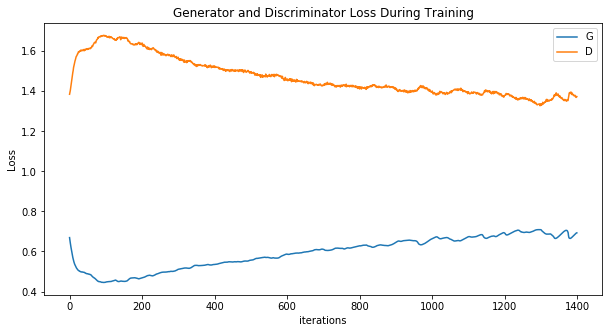

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

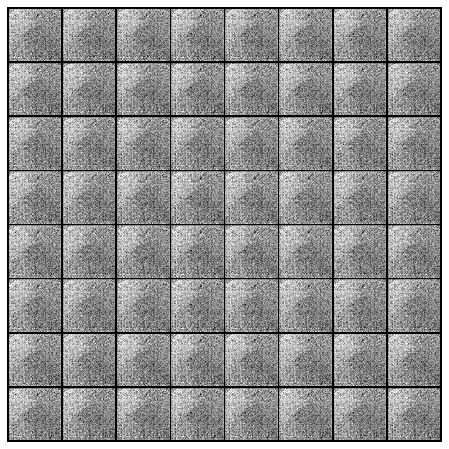

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_DualPhaseSteel"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1519.4418  Sum_of_z : 8.4600
[200]	 Ano_loss : 1508.9269  Sum_of_z : 6.3656
[400]	 Ano_loss : 1505.6156  Sum_of_z : 2.6222
picture  2
[0]	 Ano_loss : 1299.0391  Sum_of_z : 2.4467
[200]	 Ano_loss : 1286.0793  Sum_of_z : -11.5067
[400]	 Ano_loss : 1285.7722  Sum_of_z : -10.0822
picture  3
[0]	 Ano_loss : 1956.1960  Sum_of_z : -10.1607
[200]	 Ano_loss : 1950.8087  Sum_of_z : -13.5932
[400]	 Ano_loss : 1950.4353  Sum_of_z : -12.7720
picture  4
[0]	 Ano_loss : 1253.3788  Sum_of_z : -12.8276
[200]	 Ano_loss : 1247.4340  Sum_of_z : -5.5203
[400]	 Ano_loss : 1246.6221  Sum_of_z : -3.7144
picture  5
[0]	 Ano_loss : 2262.3022  Sum_of_z : -3.7218
[200]	 Ano_loss : 2257.6416  Sum_of_z : -7.9151
[400]	 Ano_loss : 2256.5703  Sum_of_z : -14.5500
picture  6
[0]	 Ano_loss : 1225.1929  Sum_of_z : -14.5222
[200]	 Ano_loss : 1220.3356  Sum_of_z : -21.7865
[400]	 Ano_loss : 1219.4469  Sum_of_z : -20.8492
picture  7
[0]	 Ano_loss : 1176.1647  Sum_of_z : -20.6013
[200]	 Ano_loss : 

---

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [16]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

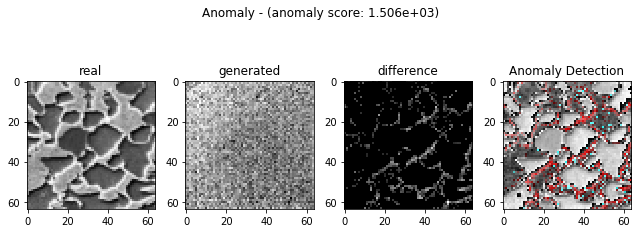

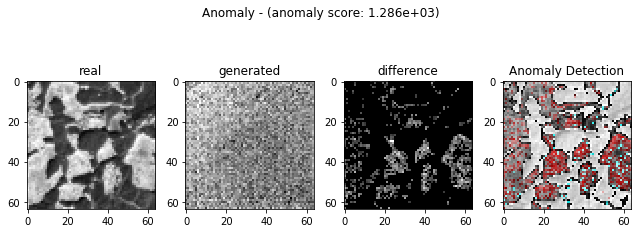

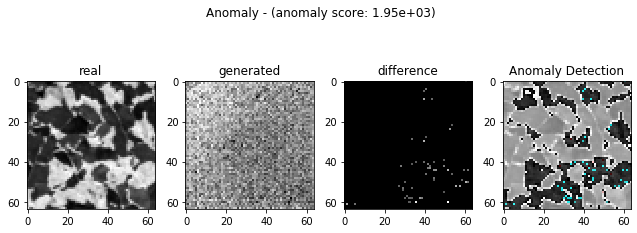

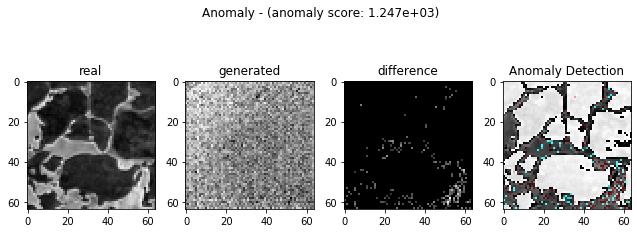

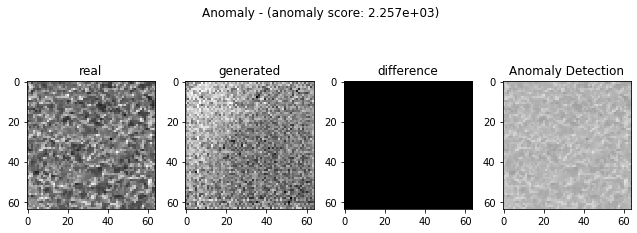

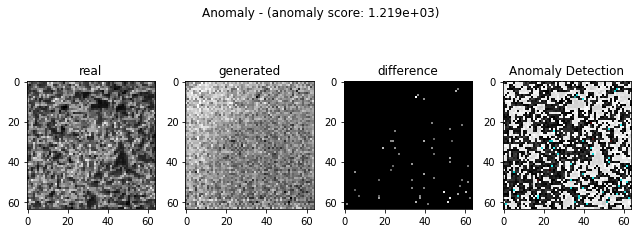

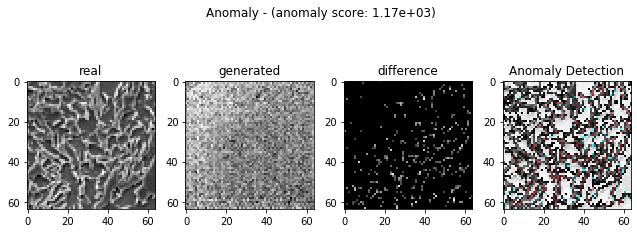

In [17]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.17504883 0.22094727 0.01269531 0.05297852 0.         0.01220703
 0.08520508]


In [19]:
print(sum(diff_fraction)/len(diff_fraction))


0.07986886160714286


---

# 분산 추출

In [ ]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# 모델 저장 및 읽기

In [ ]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [ ]:
save_pretrained()

In [ ]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [ ]:
load_pretrained()

In [ ]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [ ]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [ ]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

In [ ]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

In [ ]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [ ]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# anomaly detection 이미지 추출

In [ ]:
anomaly_imgs

# 이미지 저장 함수

In [ ]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [ ]:
save_imgs("./anomaly_imgs", anomaly_imgs)

---

# 티타늄(Ti64) 상대 밀도 계산

In [ ]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)